In [1]:
from collect_data import *
from collect_metrics import *
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# check device
device = torch.device(
    "cuda:{}".format(0) if torch.cuda.is_available() else "cpu"
)

In [3]:
stimuli_path = meg_path + '/stimuli/audio'
wav_files_duration = {}

for filename in os.listdir(stimuli_path):
    if filename.endswith('.wav'): 
        file_path = os.path.join(stimuli_path, filename)
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        wav_files_duration[filename.rstrip('.wav')] = duration
print('WAVE FILES DURATION: ',wav_files_duration)
print('WAVE FILES WITH\ NUMBERS: ',task)
wav_list_without_numb = list(task.keys())


megsp_path = os.path.join(meg_path, 'collect_data/megsp')
megsp_list = os.listdir(megsp_path)

megsp_list_session_0 = [f for f in megsp_list if f.split('_')[1] == '0']
megsp_list_session_1 = [f for f in megsp_list if f.split('_')[1] == '1']

meg_0_tensor_train, meg_0_tensor_valid, meg_0_tensor_test = get_splitted_tensor(megsp_list_session_0, megsp_path)
meg_1_tensor_train, meg_1_tensor_valid, meg_1_tensor_test = get_splitted_tensor(megsp_list_session_1, megsp_path)
meg_tensor_train = torch.cat((meg_0_tensor_train, meg_1_tensor_train), 0)
meg_tensor_valid = torch.cat((meg_0_tensor_valid, meg_1_tensor_valid), 0)
meg_tensor_test = torch.cat((meg_0_tensor_test, meg_1_tensor_test), 0)
print('DIMENSION_MEG_TENSOR_TRAIN: ', meg_tensor_train.shape)
print('DIMENSION_MEG_TENSOR_VALID: ', meg_tensor_valid.shape)
print('DIMENSION_MEG_TENSOR_TEST: ', meg_tensor_test.shape)

WAVE FILES DURATION:  {'lw1': 318.1481632653061, 'lw1_3': 53.072426303854876, 'lw1_2': 93.7512925170068, 'lw1_1': 75.44276643990929, 'lw1_0': 95.88167800453515, 'easy_money_7': 129.30312925170068, 'easy_money_6': 123.42730158730159, 'easy_money_4': 163.68920634920636, 'easy_money_5': 142.36866213151927, 'easy_money_3': 141.97519274376418, 'easy_money_0': 143.12875283446712, 'easy_money_2': 180.43360544217688, 'easy_money_1': 104.10834467120182, 'cable_spool_fort_4': 123.26390022675737, 'cable_spool_fort_5': 54.69605442176871, 'cable_spool_fort_3': 105.82820861678005, 'cable_spool_fort_2': 137.65614512471655, 'cable_spool_fort_1': 134.8726984126984, 'cable_spool_fort_0': 100.59777777777778, 'the_black_willow_9': 188.23668934240362, 'the_black_willow_8': 142.4142403628118, 'the_black_willow_7': 172.399410430839, 'the_black_willow_6': 128.21628117913832, 'the_black_willow_5': 81.94331065759637, 'the_black_willow_4': 110.45659863945578, 'the_black_willow_2': 125.23859410430839, 'the_black_

In [4]:
real_target = []
for channel in range(num_channel):
    y_test = meg_tensor_test[:, channel, :, :].reshape(meg_tensor_test.shape[0], -1)
    real_target.append(y_test)

pred_mse_scores_w2v = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge_w2v.pt'))
pred_meg_y_w2v = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge_w2v.pt'))
pred_meg_y_w2v = pred_meg_y_w2v.permute(1, 0, 2)
pred_mse_scores_gpt = torch.load(os.path.join(meg_path, 'collect_data/meg_mse_ridge_text_gpt.pt'))
pred_meg_y_gpt = torch.load(os.path.join(meg_path, 'collect_data/meg_prediction_ridge_text_gpt.pt'))
pred_meg_y_gpt = pred_meg_y_gpt.permute(1, 0, 2)
real_target = torch.tensor(np.array(real_target))
real_target = real_target.permute(1, 0, 2)
print("PREDICTION_SHAPE_W2V:", pred_meg_y_w2v.shape)
print("PREDICTION_SHAPE_GPT:", pred_meg_y_gpt.shape)
print("REAL_TARGET_SHAPE:", real_target.shape)

PREDICTION_SHAPE_W2V: torch.Size([3480, 208, 416])
PREDICTION_SHAPE_GPT: torch.Size([3460, 208, 416])
REAL_TARGET_SHAPE: torch.Size([3480, 208, 416])


In [5]:
real_target_gpt = real_target[19:-1]
correlations_w2v = np.array([np.corrcoef(real_target[:,i], pred_meg_y_w2v[:,i])[0, 1] for i in range(num_channel)])
correlations_gpt = np.array([np.corrcoef(real_target_gpt[:,i], pred_meg_y_gpt[:,i])[0, 1] for i in range(num_channel)])


In [8]:
pred_meg_y_w2v = pred_meg_y_w2v.reshape(-1, num_channel, 16, 26)
real_target = real_target.reshape(-1, num_channel, 16, 26)
pred_meg_y_gpt = pred_meg_y_gpt.reshape(-1, num_channel, 16, 26)
print(pred_meg_y_w2v.shape)
print(pred_meg_y_gpt.shape)
print(real_target.shape)

torch.Size([3480, 208, 16, 26])
torch.Size([3460, 208, 16, 26])
torch.Size([3480, 208, 16, 26])


In [9]:
freq_bands = {
    'delta': [0, 2],
    'theta': [2, 4],
    'alpha': [4, 7],
    'beta': [7, 16],
}

metrics_by_band_w2v, corr_matrix_w2v = bands_metrics(real_target, pred_meg_y_w2v, freq_bands)
metrics_by_band_gpt, corr_matrix_gpt = bands_metrics(real_target[19:-1], pred_meg_y_gpt, freq_bands)

In [12]:
delta_corr_w2v = corr_matrix_w2v['delta'][0]['corr_matrix']
theta_corr_w2v = corr_matrix_w2v['theta'][0]['corr_matrix']
alpha_corr_w2v = corr_matrix_w2v['alpha'][0]['corr_matrix']
beta_corr_w2v = corr_matrix_w2v['beta'][0]['corr_matrix']

delta_corr_gpt = corr_matrix_gpt['delta'][0]['corr_matrix']
theta_corr_gpt = corr_matrix_gpt['theta'][0]['corr_matrix']
alpha_corr_gpt = corr_matrix_gpt['alpha'][0]['corr_matrix']
beta_corr_gpt = corr_matrix_gpt['beta'][0]['corr_matrix']

delta_corr = [a - b for a, b in zip(delta_corr_w2v, delta_corr_gpt)]
theta_corr = [a - b for a, b in zip(theta_corr_w2v, theta_corr_gpt)]
alpha_corr = [a - b for a, b in zip(alpha_corr_w2v, alpha_corr_gpt)]
beta_corr = [a - b for a, b in zip(beta_corr_w2v, beta_corr_gpt)]

correlations = [a - b for a, b in zip(correlations_w2v, correlations_gpt)]


In [14]:
print('MIN delta_corr: ',min(delta_corr))
print('MIN theta_corr: ',min(theta_corr))
print('MIN alpha_corr: ',min(alpha_corr))
print('MIN beta_corr: ',min(beta_corr))
print('MIN corr: ',min(correlations))

print('MAX delta_corr: ',max(delta_corr))
print('MAX theta_corr: ',max(theta_corr))
print('MAX alpha_corr: ',max(alpha_corr))
print('MAX beta_corr: ',max(beta_corr))
print('MAX corr: ',max(correlations))

MIN delta_corr:  -0.826380867545362
MIN theta_corr:  -0.5751713476146044
MIN alpha_corr:  -0.4791153338134521
MIN beta_corr:  -0.38518862766051976
MIN corr:  -0.2986606655514963
MAX delta_corr:  0.8702130078433106
MAX theta_corr:  0.7209946126048623
MAX alpha_corr:  0.6280947090640212
MAX beta_corr:  0.4275856894516791
MAX corr:  0.4361250854073442


Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:49: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


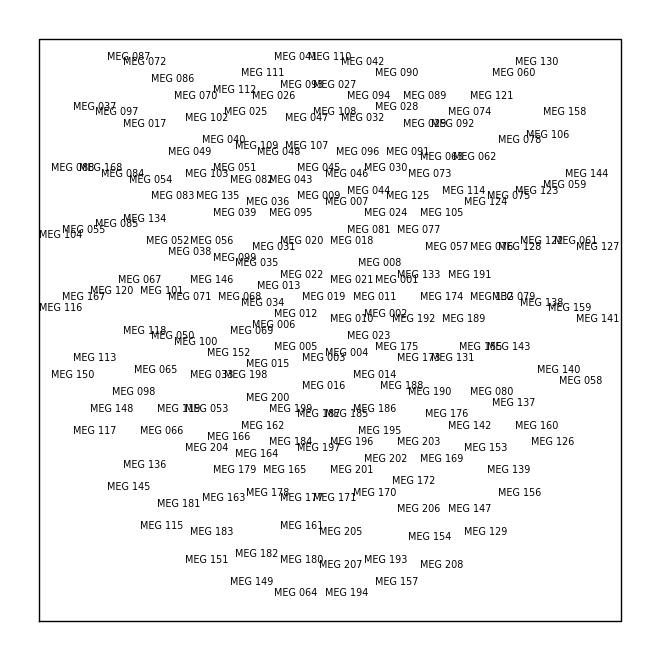

Figure(640x640)


In [15]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')
layout_from_raw = mne.channels.find_layout(raw.info, ch_type='mag')
print(layout_from_raw.plot())

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


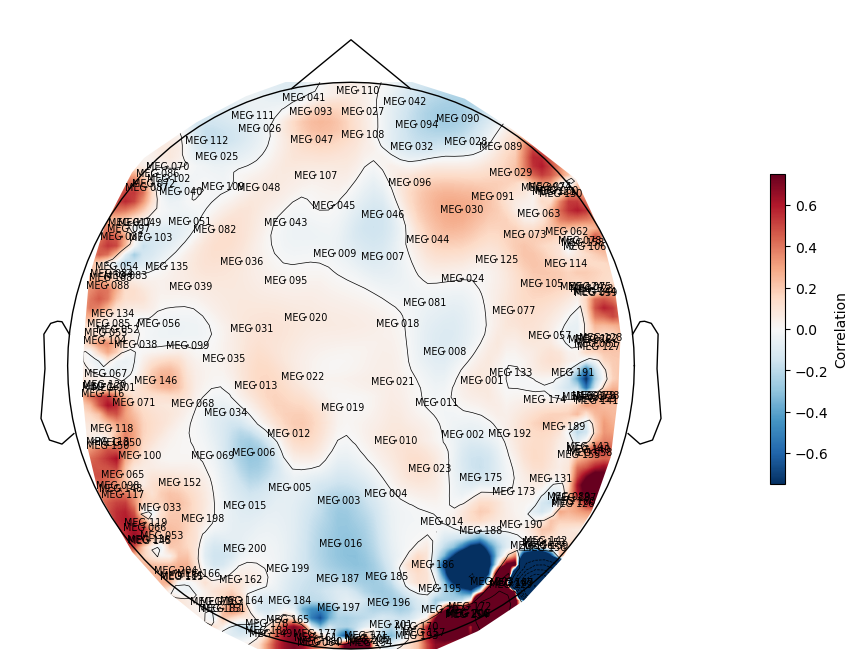

In [20]:
get_topomap(raw, correlations, (-0.75, 0.75))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


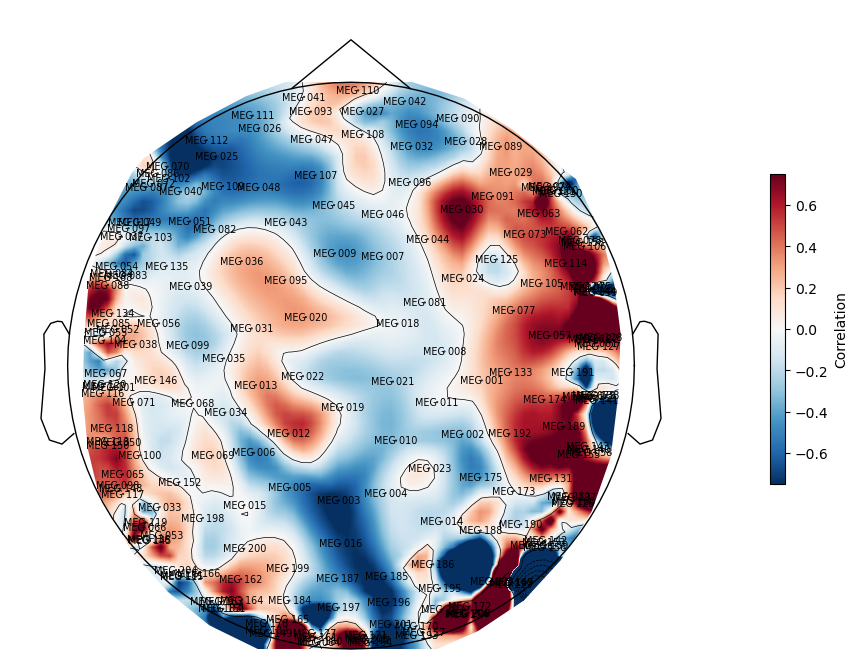

In [16]:
get_topomap(raw, delta_corr, (-0.75, 0.75))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


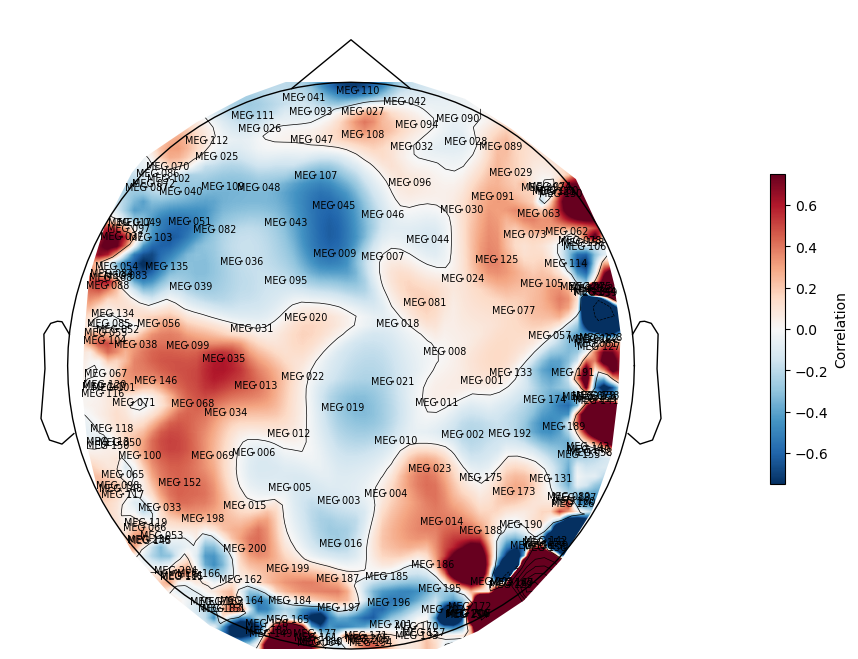

In [17]:
get_topomap(raw, theta_corr, (-0.75, 0.75))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


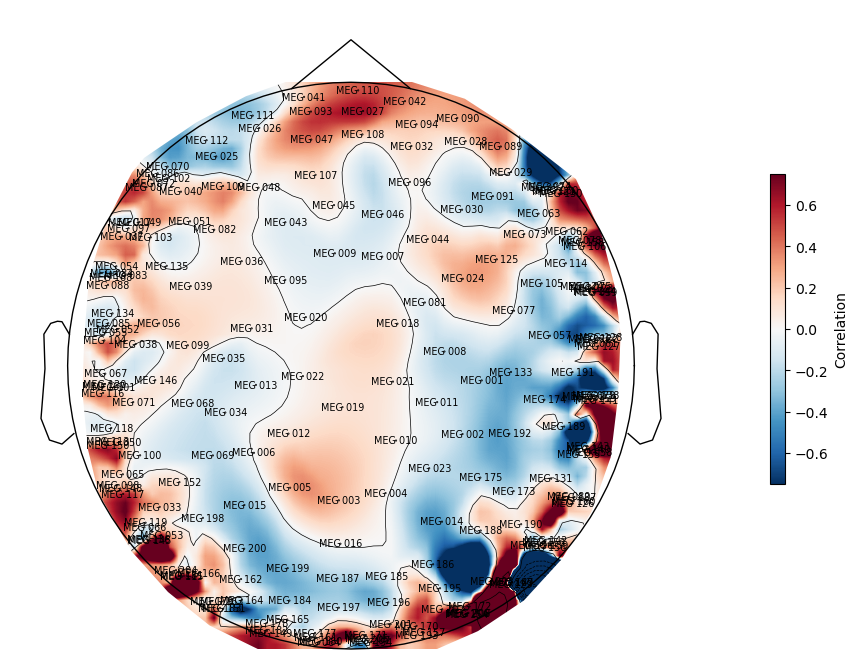

In [18]:
get_topomap(raw, alpha_corr, (-0.75, 0.75))

meg_channel_positions.shape:  (208, 2)
correlations.shape:  (208,)


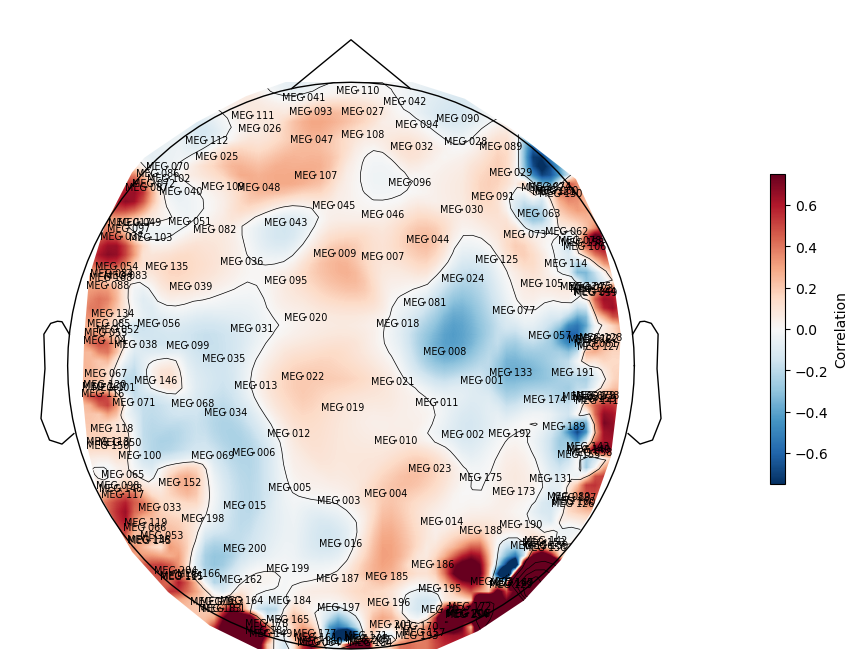

In [19]:
get_topomap(raw, beta_corr, (-0.75, 0.75))